In [82]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [83]:
# File paths
train_file = "house-prices-advanced-regression-techniques/train.csv"
test_file = "house-prices-advanced-regression-techniques/test.csv"

# Load datasets
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Add column to distinguish train vs test
train_data["Dataset"] = "train"
test_data["Dataset"] = "test"

# Merge for consistent preprocessing
combined_data = pd.concat([train_data, test_data], ignore_index=True)
combined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Dataset
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train


In [84]:
null_check = (combined_data.isnull().sum()/len(combined_data))*100
null_check.sort_values(ascending=False)

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
MasVnrType      60.500171
                  ...    
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
Dataset          0.000000
Length: 82, dtype: float64

In [85]:
def drop_columns_with_missing_values(data, threshold=40):
    """Removes columns where more than `threshold`% of values are missing."""
    missing_percent = data.isnull().mean() * 100
    columns_to_remove = missing_percent[missing_percent > threshold].index
    data = data.drop(columns=columns_to_remove)
    return data

combined_data = drop_columns_with_missing_values(combined_data)

In [86]:
combined_data = combined_data.dropna()
combined_data = combined_data.drop_duplicates()

In [87]:
def remove_highly_correlated_features(data, vif_threshold=5.0):
    """Removes numerical features that have high correlation based on VIF."""
    numeric_features = data.select_dtypes(include=["number"])
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_features.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_features.values, i) for i in range(numeric_features.shape[1])]
    
    features_to_remove = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
    data = data.drop(columns=features_to_remove)
    
    print(f"Removed highly correlated features: {features_to_remove}")
    return data

combined_data = remove_highly_correlated_features(combined_data)

c:\Users\Sushmitha Sudharsan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removed highly correlated features: ['LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MoSold', 'YrSold']


In [88]:
def scale_numeric_features(data, save_scaler=True, scaler_file="scaler.pkl"):
    """Scales numerical features using StandardScaler and saves the scaler."""
    numeric_columns = data.select_dtypes(include=["int64", "float64"]).columns
    scaler = StandardScaler()
    
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
    
    if save_scaler:
        joblib.dump(scaler, scaler_file)
    
    return data, scaler

combined_data, trained_scaler = scale_numeric_features(combined_data)

In [89]:

# Collinearity Protection: Removing highly correlated features manually
high_corr_features = ["GrLivArea", "TotalSF"]  # Protecting these features
for feature in high_corr_features:
    if feature in combined_data.columns:
        combined_data[feature] = combined_data[feature]  # Ensuring they remain
print("Collinearity Protection: Kept important features like GrLivArea and TotalSF.")


Collinearity Protection: Kept important features like GrLivArea and TotalSF.


In [90]:

from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding to categorical features
categorical_cols = combined_data.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col].astype(str))
    label_encoders[col] = le
print("Categorical Encoding: Applied Label Encoding.")


Categorical Encoding: Applied Label Encoding.


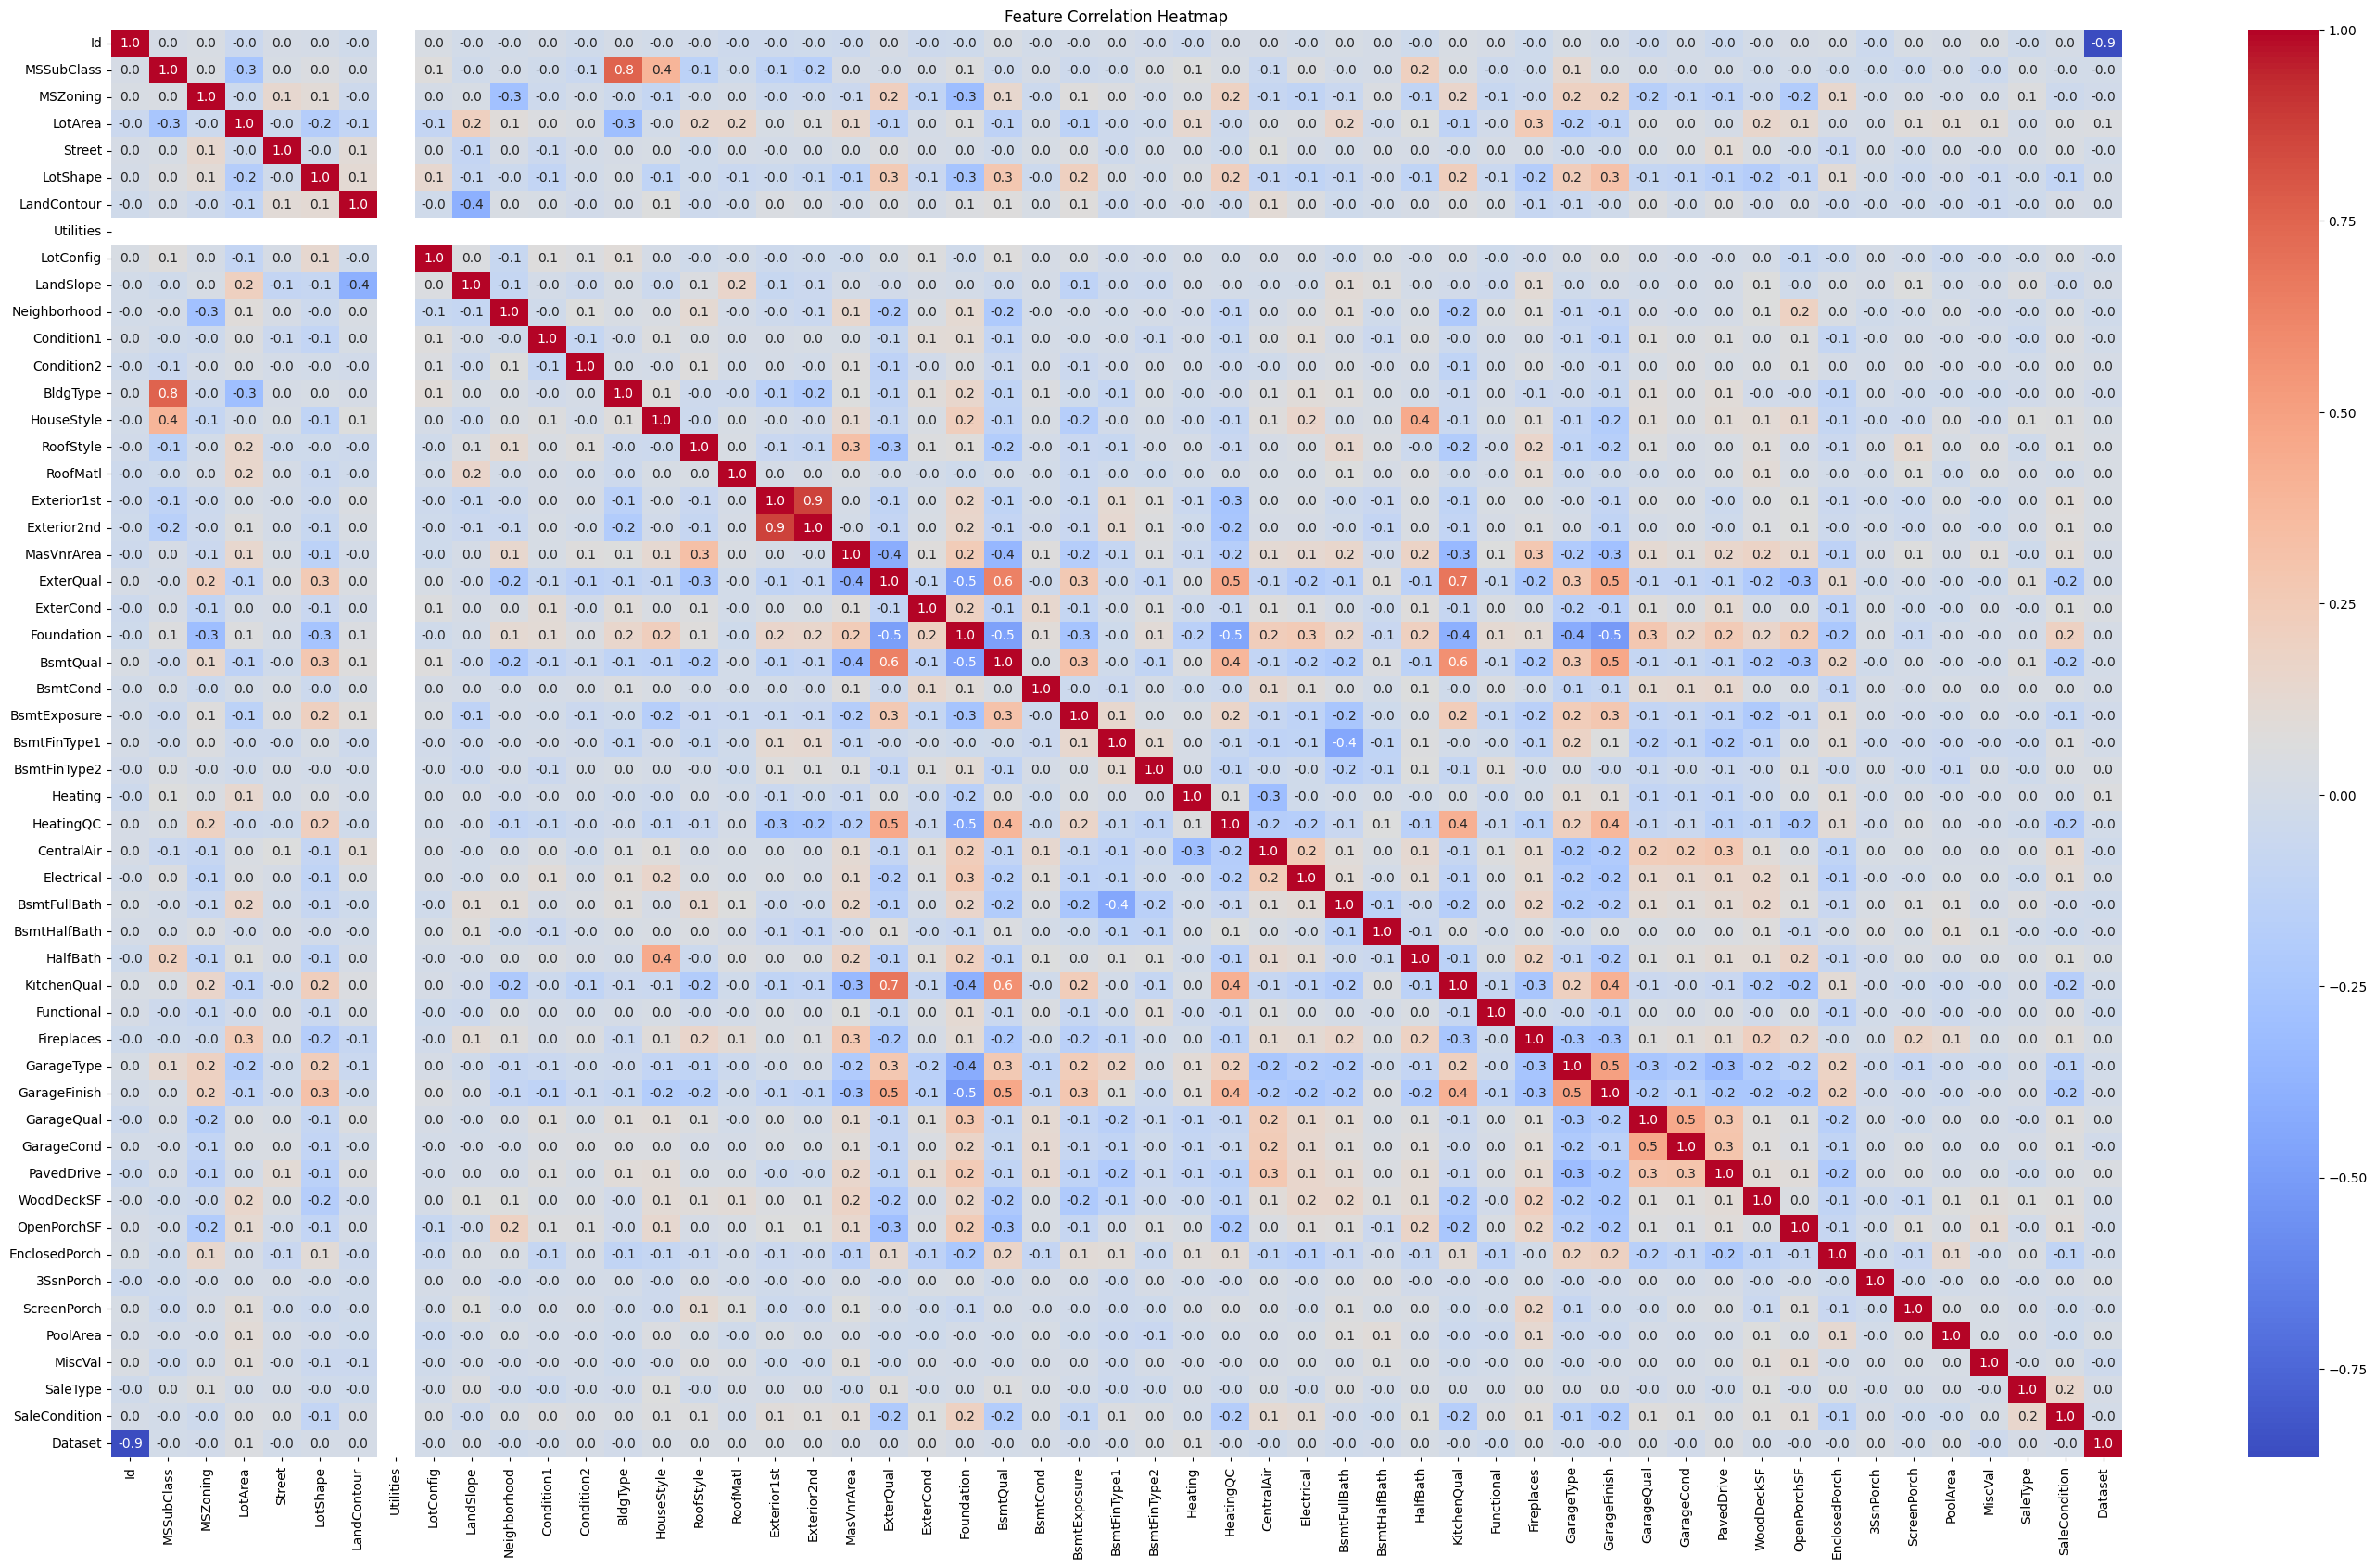

Correlation Heatmap: Saved as PNG.


In [91]:

import seaborn as sns
import matplotlib.pyplot as plt

# Generate Correlation Heatmap
plt.figure(figsize=(35, 20))
sns.heatmap(combined_data.corr(), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Feature Correlation Heatmap")
plt.savefig("correlation_heatmap.png")
plt.show()
print("Correlation Heatmap: Saved as PNG.")


In [92]:

# One-Hot Encoding for categorical variables
combined_data = pd.get_dummies(combined_data, drop_first=True)
print("One-Hot Encoding: Applied pd.get_dummies().")

One-Hot Encoding: Applied pd.get_dummies().


In [93]:
combined_data

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,Dataset
0,-1.733014,0.082676,3,-0.207025,1,3,3,0,4,0,...,-0.765270,0.199743,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,4,1
1,-1.731827,-0.861027,3,-0.030900,1,3,3,0,2,0,...,1.656425,-0.721652,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,4,1
2,-1.730641,0.082676,3,0.221801,1,0,3,0,4,0,...,-0.765270,-0.087249,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,4,1
3,-1.729454,0.318601,3,-0.038558,1,0,3,0,0,0,...,-0.765270,-0.192983,3.882144,-0.099242,-0.296336,-0.06651,-0.084499,8,0,1
4,-1.728267,0.082676,3,0.682790,1,0,3,0,2,0,...,0.795017,0.547155,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,1.721517,-0.861027,3,0.548629,1,3,3,0,4,1,...,0.534969,-0.721652,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,4,0
2912,1.722704,2.441931,4,-1.266380,1,3,3,0,4,0,...,-0.765270,-0.721652,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,0,0
2915,1.726264,2.441931,4,-1.211092,1,3,3,0,4,0,...,-0.765270,-0.359136,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,0,0
2916,1.727451,-0.861027,3,1.561885,1,3,3,0,4,0,...,3.086688,-0.721652,-0.354190,-0.099242,-0.296336,-0.06651,-0.084499,8,0,0


In [94]:
train_cleaned = combined_data[combined_data["Dataset"] == "train"]
test_cleaned = combined_data[combined_data["Dataset"] == "test"]

In [99]:
# Checking the values in the 'Dataset' column
if "Dataset" in combined_data.columns:
    print(combined_data["Dataset"].unique())  # Inspect unique values

    # If the column exists and has values like "Train", "TEST", you can filter based on them
    train_cleaned = combined_data[combined_data["Dataset"] == "train"]
    test_cleaned = combined_data[combined_data["Dataset"] == "test"]
else:
    print("The 'Dataset' column is missing. Please check your data.")

[1 0]


In [101]:
# Strip any extra spaces and convert to lowercase to ensure matching
combined_data["Dataset"] = combined_data["Dataset"].str.strip().str.lower()

# Now filter the data
train_cleaned = combined_data[combined_data["Dataset"] == "train"]
test_cleaned = combined_data[combined_data["Dataset"] == "test"]

# Check the filtered data
print(train_cleaned.head())  # Check the first few rows of train_cleaned
print(test_cleaned.head())   # Check the first few rows of test_cleaned

AttributeError: Can only use .str accessor with string values!

In [100]:
train_cleaned

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,Dataset


In [95]:
train_cleaned

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,Dataset


In [63]:
train_cleaned.to_csv("cleaned_train.csv", index=False)
test_cleaned.to_csv("cleaned_test.csv", index=False)

In [64]:
df = pd.read_csv("cleaned_train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition
